Data cleaning is definitely a "practice makes perfect" skill. In this challenge, you'll use this dataset of article open-access prices paid by the WELLCOME Trust between 2012 and 2013.

You can find the CSV file here and a description of the dataset here.

To complete this challenge, determine the five most common journals and the total articles for each. Next, calculate the mean, median, and standard deviation of the open-access cost per article for each journal.

You will need to do considerable data cleaning in order to extract accurate estimates. You may want to look into data encoding methods if you get stuck. For a real bonus round, identify the open access prices paid by subject area.

Remember not to modify the data directly. Instead, write a cleaning script that will load the raw data and whip it into shape. Jupyter notebooks are a great format for this. Keep a record of your decisions: well-commented code is a must for recording your data cleaning decision-making progress. Submit a link to your script and results below and discuss it with your mentor at your next session.

In [869]:
# import relevant packages. This is iterative based on new needs
import pandas as pd
import scipy.stats
from scipy.stats.mstats import winsorize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
df = pd.read_csv("WELLCOME_APCspend2013_forThinkful.csv", encoding = "ISO-8859-1") # add this to read UTF 8 encoding

In [3]:
df.head()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88


In [890]:
# copy original df so nothing is permantly changed in raw file
df_2 = df.copy()

In [891]:
# dtypes gives broad insight into types of data and whether it makes sense with the column info.
# In this case, the last column that is based around cost should be either a float or int, but it is an object.
# This suggests there are multiple data types in the cost column that need to be taken out.
df_2.dtypes

PMID/PMCID                                             object
Publisher                                              object
Journal title                                          object
Article title                                          object
COST (£) charged to Wellcome (inc VAT when charged)    object
dtype: object

In [892]:
df_2.describe(include = 'all')

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
count,1928,2127,2126,2127,2127
unique,1880,299,984,2126,1402
top,-,Elsevier,PLoS One,"Exclusive breastfeeding, diarrhoel morbidity a...",£2040.00
freq,7,387,92,2,94


In [893]:
# before any of the following code works properly, the column names need to be formally renamed to fit within the python standard
# removed special characters, lower case, and applied strip for white space

df_2.columns = df_2.columns.str.strip().str.lower().str.replace("&", "and").str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('/','_').str.replace('.', '').str.replace('"','')
print(df_2.columns)

Index(['pmid_pmcid', 'publisher', 'journal_title', 'article_title',
       'cost_£_charged_to_wellcome_inc_vat_when_charged'],
      dtype='object')


In [894]:
# column name is WAY too long. renamed it for readability... not sure if it's best to use the sterling name or symbol

df_2.rename(columns={'cost_£_charged_to_wellcome_inc_vat_when_charged':'cost_sterling'}, inplace=True)

In [895]:
# Notice above in the df.head() that there are nulls in this data set. 
# This allows us to see the number of nulls in each column and that can guide us on how/if we need to fix, fill, or remove.
df_2.isna().sum()

pmid_pmcid       199
publisher          0
journal_title      1
article_title      0
cost_sterling      0
dtype: int64

In [896]:
# Broke down the nulls by pmid_pmcid (column with most nulls) with a focus on journal_title (column the study is focused on)
# to see if it's significantly focused on one or just a few journal titles.
# Here, it seems the nulls are decently well distributed.

df_11 = df_2.pmid_pmcid.isnull().groupby([df_2['journal_title']]).sum().astype(int).reset_index(name='count')

print(df_11.sort_values(by = ['count'], ascending=False) .where(df_11['count'] > 0))


                                      journal_title  count
782                                          PLoS 1    7.0
115                                             BMJ    5.0
27    Advances in Experimental Medicine and Biology    4.0
961                          Trends in Parasitology    4.0
599                         Journal of Neuroscience    3.0
625               Journal of Visualized Experiments    3.0
236                                 Chronic Illness    3.0
283                              Developmental Cell    3.0
161                                           Blood    3.0
640  Journal of the International African Institute    3.0
164                                           Brain    3.0
730                            Neuroimage: Clinical    2.0
430                        Human Molecular Genetics    2.0
421                                      Hepatology    2.0
39                             American Ethnologist    2.0
112                               BMC Public Health    2

In [897]:
# The PMID/PMCID column has the bulk of nulls. The write-up suggested that this column is to ID whether an article is in the 
# PMC/Europe PMC and may not be 100% accurate. In addition, the nulls appear not to cluster too bad in any one journal title. 
# Since these IDs are manually assigned, it's likely that there's missing logic on how to appropriately infill the missing IDs.
# Filling in or fixing these nulls won't work based on current knowledge.

# Removing all nulls
print(df_2.dropna(inplace= True)) 

None


In [898]:
# Confirming rows with nulls are gone

df_2.isna().sum()

pmid_pmcid       0
publisher        0
journal_title    0
article_title    0
cost_sterling    0
dtype: int64

In [899]:
# First pass stripping data for excess white space

cols = df_2.select_dtypes(['object']).columns
df_2[cols] = df_2[cols].apply(lambda x: x.str.strip())
df_2.head()

,pmid_pmcid,publisher,journal_title,article_title,cost_sterling
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88
5,PMC3579457,ACS,Journal of Medicinal Chemistry,Comparative Structural and Functional Studies ...,£2392.20


In [900]:
# Long process to clean up values in the columns.

df_2['journal_title'] = df_2['journal_title'].str.replace("&", "and").str.replace('(', '').str.replace(')', '').str.replace('/','_').str.replace('.', '').str.replace('"','')

In [901]:
df_2.head()

,pmid_pmcid,publisher,journal_title,article_title,cost_sterling
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88
5,PMC3579457,ACS,Journal of Medicinal Chemistry,Comparative Structural and Functional Studies ...,£2392.20


In [902]:
# Are there any similar journal titles that have inconsistent labeling?

# YES... yes, there are.

df_2.journal_title.value_counts()

PLoS One                                                   91
PLoS ONE                                                   62
Journal of Biological Chemistry                            47
Nucleic Acids Research                                     23
Proceedings of the National Academy of Sciences            21
PLoS Neglected Tropical Diseases                           18
Nature Communications                                      17
Human Molecular Genetics                                   16
PLoS Pathogens                                             15
NeuroImage                                                 14
Neuroimage                                                 14
PLoS Genetics                                              14
PLOS ONE                                                   13
Movement Disorders                                         13
BMC Public Health                                          12
Biochemical Journal                                        11
Journal 

In [903]:
# We could simply capitalize or lowercase all text, but this column reflects journal titles, which have a normal standard of formating. 
# str.title() capitalizes each first word in strings.

df_2['journal_title'] = df_2.journal_title.str.title()

In [904]:
#no_caps_list = ["and", "is", "it", "if", "of", "the", "a"]

# Apply lowercase on specific words like "of" and "is".
df_2['journal_title'] = df_2['journal_title'].str.replace("And", "and").str.replace(' Is ', ' is ').str.replace(' If ', ' if ').str.replace(' Uk ', ' UK ').str.replace('Virology Journal', 'Virology ').str.replace('Trials ', 'Trials ').str.replace(' Of ',' of ').str.replace(' A ',' a ').str.replace(' The ',' the ')


In [905]:
# Notice! There is only 1 listing for "Plos One" and count went way up.
# Also notice, be careful of country abbreviation. UK was Uk, and a couple other strings looked similar.
# Iteratively, these fixes were addressed in the str.replace cell.

df_2.journal_title.value_counts()

Plos One                                                   188
Journal of Biological Chemistry                             52
Neuroimage                                                  28
Nucleic Acids Research                                      25
Plos Pathogens                                              24
Plos Genetics                                               23
Proceedings of the National Academy of Sciences             22
Plos Neglected Tropical Diseases                            20
Nature Communications                                       19
Human Molecular Genetics                                    17
Movement Disorders                                          13
Bmc Public Health                                           12
Biochemical Journal                                         11
Journal of General Virology                                 11
Brain                                                       11
Malaria Journal                                        

### Find the top 5 counts of journal titles

In [906]:
# Find the top 5 counts of journal titles!

print('The top 5 journals are:\n')
top_five = df_2['journal_title'].value_counts().nlargest(5)
print(top_five)

The top 5 journals are:

Plos One                           188
Journal of Biological Chemistry     52
Neuroimage                          28
Nucleic Acids Research              25
Plos Pathogens                      24
Name: journal_title, dtype: int64


In [907]:
# Work towards removing the currency symbols in the cost column.

def is_a_digit(x):
    # First make sure we're operating on a string, then use our string method.
    return str(x).isdigit()

# Now let's apply our custom function to each element in our series.
print(df_2.cost_sterling.apply(is_a_digit))

1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
        ...  
2097    False
2098    False
2099    False
2100    False
2101    False
2102    False
2103    False
2104    False
2105    False
2106    False
2107    False
2108    False
2109    False
2110    False
2111    False
2112    False
2113    False
2114    False
2115    False
2116    False
2117    False
2118    False
2119    False
2120    False
2121    False
2122    False
2123    False
2124    False
2125    False
2126    False
Name: cost_sterling, Length: 1928, dtype: bool


In [908]:
# Removing the currency symbol.
# Did not convert cells with $ symbols because the read me file said all values were already converted to Sterling(£)

df_2['cost_sterling'] = df_2.cost_sterling.str.replace('£', '').str.replace('$', '').astype(float)

In [909]:
df_2.head()

,pmid_pmcid,publisher,journal_title,article_title,cost_sterling
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,685.88
5,PMC3579457,ACS,Journal of Medicinal Chemistry,Comparative Structural and Functional Studies ...,2392.20


Text(0.5,1,'Box plot of cost sterling')

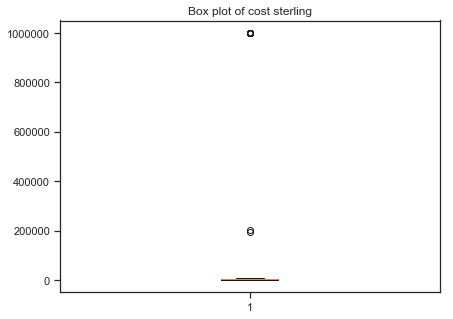

In [910]:
# Got to the end of this assignment with much happiness until I dug deeper into the results.
# It became clear that a step was skipped in regards to outliers. Mean and median did not seem to make sense, as well as 
# summary statistic tables and general histograms.
# Decided to winsorize in order to keep the dataframe the same length.

# This box plot makes it very clear how off these outliers are. However, in the future, think about what data is being transformed.
# There could be some collatoral damage with broad strokes like this.

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(df_2['cost_sterling'], whis = 5)
plt.title("Box plot of cost sterling")

In [911]:
df_2['winsorized_cost_sterling'] = winsorize(df_2['cost_sterling'],(0.05, 0.05))

Text(0.5,1,'Box plot of winsorized cost sterling')

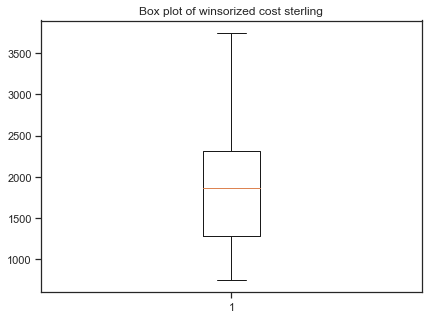

In [913]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.boxplot(df_2['winsorized_cost_sterling'], whis = 5)
plt.title("Box plot of winsorized cost sterling")

### Calculate the mean, median, and standard deviation of the open-access cost per article for each journal.

In [914]:
# This was the hardest part of the entire excercise.
# Needed to apply the .agg method in order to apply multiple aggregations for a single grouped data frame.
# Added a bonus total article column to use later for the nlargest method.

df_summary = df_2.groupby(['journal_title'])['winsorized_cost_sterling'].agg([np.sum, pd.Series.count, np.mean, np.median, np.std])
df_summary.columns = ['total_cost_sterling','total_articles', 'avg_cost_per_article', 'median_cost_per_article', 'std_cost_per_article']
df_summary = df_summary.reset_index().sort_values(['total_articles'])

In [915]:
# All values are grouped by journal title with no sorting. DON'T FREAK OUT if you see weird values. You're not done yet.

df_summary.head()

,journal_title,total_cost_sterling,total_articles,avg_cost_per_article,median_cost_per_article,std_cost_per_article
0,Academy of Nutrition and Dietetics,2379.54,1.0,2379.54,2379.54,NaN
453,Journal of Cellular Biochemistry,1971.87,1.0,1971.87,1971.87,NaN
455,Journal of Chemical Information and Modeling,1329.69,1.0,1329.69,1329.69,NaN
456,Journal of Cheminformatics,882.12,1.0,882.12,882.12,NaN
458,Journal of Clinical Endocrinology,1970.57,1.0,1970.57,1970.57,NaN


In [916]:
#Found more nulls, but this time, they are in a different column. Let's find out where they are like we did earlier.

df_12 = df_summary.std_cost_per_article.isnull().groupby([df_2['journal_title']]).sum().astype(int).reset_index(name='count')

print(df_12.sort_values(by = ['count'], ascending=False) .where(df_11['count'] > 0))

                                      journal_title  count
195                 Journal of Biological Chemistry   31.0
273                                             NaN    NaN
246                                             NaN    NaN
73                                              NaN    NaN
69                                Bmc Public Health    7.0
91                                              NaN    NaN
110                                             NaN    NaN
196                                             NaN    NaN
217                                             NaN    NaN
231                   Journal of Structural Biology    6.0
106                                             NaN    NaN
221                                             NaN    NaN
276                                          Neuron    5.0
117                                             NaN    NaN
113                                             NaN    NaN
318                     Social Science and Medicine    5

In [917]:
# Found out there are many nulls, LET'S DELETE THEM!

print(df_summary.dropna(inplace= True)) 

None


In [918]:
# Confirming rows with nulls are gone

df_summary.isna().sum()

journal_title              0
total_cost_sterling        0
total_articles             0
avg_cost_per_article       0
median_cost_per_article    0
std_cost_per_article       0
dtype: int64

In [919]:
# Iterative Process!!! Median showed a red flag to check. Let's plot out median cost by group.
# Vision Research has a huge median cost per article. However, it very well could just have very expensive research and
# has only 2 articles. For this purpose and since we're focused on most common journal title, I wouldn't winsorize.

df_ordered_summary = df_summary.sort_values(by = ['median_cost_per_article'], ascending = False)
df_ordered_summary.head(20)

,journal_title,total_cost_sterling,total_articles,avg_cost_per_article,median_cost_per_article,std_cost_per_article
748,Structure,26116.83,7.0,3730.975714,3748.000,45.042026
174,Cell Host and Microbe,7496.00,2.0,3748.000000,3748.000,0.000000
167,Cell,15818.77,5.0,3163.754000,3748.000,1031.707471
178,Cell Reports,31949.03,9.0,3549.892222,3748.000,290.808678
772,The Lancet,7496.00,2.0,3748.000000,3748.000,0.000000
379,Immunity,7496.00,2.0,3748.000000,3748.000,0.000000
224,Current Biology,33831.48,10.0,3383.148000,3748.000,941.228021
241,Developmental Cell,30094.88,9.0,3343.875556,3748.000,897.949970
578,Molecular Cell,18714.39,5.0,3742.878000,3748.000,11.453140
615,Neuron,26838.37,8.0,3354.796250,3748.000,1054.809225


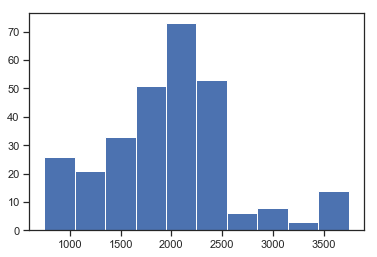

In [920]:
plt.hist(df_summary.median_cost_per_article)

plt.show()

In [921]:
# Apply the nlargest method on total articles to filter only to the top 5 journals.
# This basically is basically the answer, but LOOK AT ALL THOSE DECIMAL POINTS!!

df_top_five_journals = df_summary.nlargest(5,['total_articles'])
df_top_five_journals.head()

,journal_title,total_cost_sterling,total_articles,avg_cost_per_article,median_cost_per_article,std_cost_per_article
668,Plos One,201191.07,188.0,1070.165266,899.74,589.408301
448,Journal of Biological Chemistry,76995.08,52.0,1480.674615,1328.96,504.468612
610,Neuroimage,62460.12,28.0,2230.718571,2335.04,257.809151
628,Nucleic Acids Research,29059.05,25.0,1162.362000,852.00,446.331166
669,Plos Pathogens,42099.07,24.0,1754.127917,1600.52,633.263076


In [922]:
# Cleaning up column decimal points to round to just 2. There are other methods, but this one worked just fine.

cols_2 = df_top_five_journals.select_dtypes(['float']).columns
df_top_five_journals[cols_2] = df_top_five_journals[cols_2].round(decimals=2)
df_top_five_journals = df_top_five_journals.sort_values(by = ['total_cost_sterling'], ascending=False)

print('Here are the means, medians, and standard deviations for the cost of the top 5 journals per article:')
df_top_five_journals.head()

Here are the means, medians, and standard deviations for the cost of the top 5 journals per article:


,journal_title,total_cost_sterling,total_articles,avg_cost_per_article,median_cost_per_article,std_cost_per_article
668,Plos One,201191.07,188.0,1070.17,899.74,589.41
448,Journal of Biological Chemistry,76995.08,52.0,1480.67,1328.96,504.47
610,Neuroimage,62460.12,28.0,2230.72,2335.04,257.81
669,Plos Pathogens,42099.07,24.0,1754.13,1600.52,633.26
628,Nucleic Acids Research,29059.05,25.0,1162.36,852.00,446.33


In [923]:
df_top_five_journals.describe()

,total_cost_sterling,total_articles,avg_cost_per_article,median_cost_per_article,std_cost_per_article
count,5.000000,5.000000,5.000000,5.00000,5.000000
mean,82360.878000,63.400000,1539.610000,1403.25200,486.256000
std,68933.925863,70.596034,471.650629,606.23138,146.939047
min,29059.050000,24.000000,1070.170000,852.00000,257.810000
25%,42099.070000,25.000000,1162.360000,899.74000,446.330000
50%,62460.120000,28.000000,1480.670000,1328.96000,504.470000
75%,76995.080000,52.000000,1754.130000,1600.52000,589.410000
max,201191.070000,188.000000,2230.720000,2335.04000,633.260000


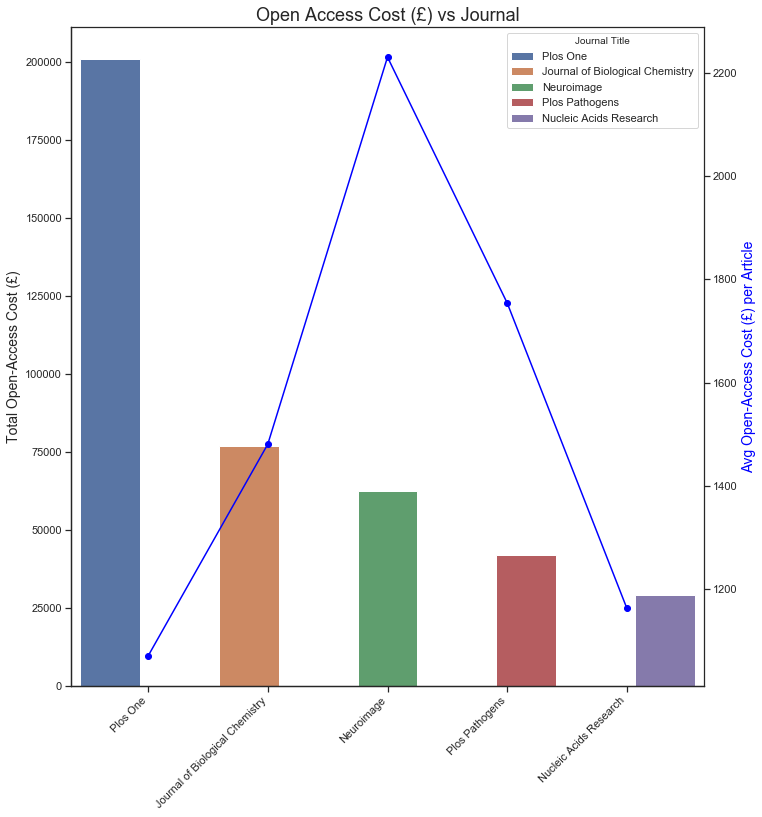

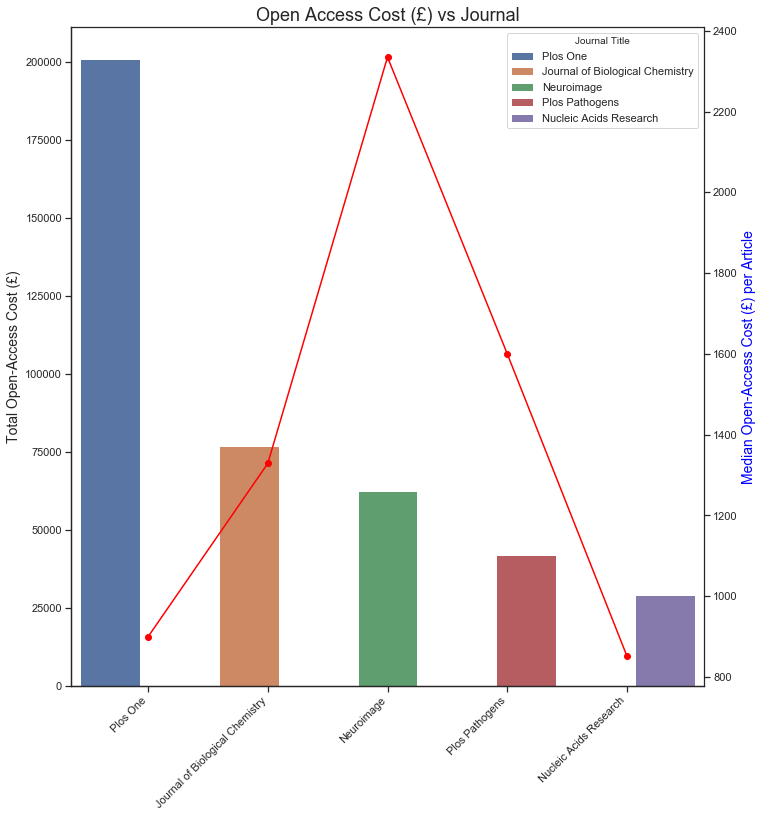

In [924]:
# Being the nerd that I am, I wanted to see if there were any correlations between total cost and cost per article using seaborn.

fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
g=sns.barplot(x='journal_title', y='total_cost_sterling', data=df_top_five_journals, hue="journal_title",ax=ax)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
        
change_width(ax, .5)
plt.fontsize = 7
plt.tight_layout()
plt.xticks(rotation = 45, horizontalalignment='right')
sns.despine(trim=False)

        # twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_top_five_journals.journal_title, df_top_five_journals.avg_cost_per_article,color="blue",marker="o")
ax2.set_ylabel('Avg Open-Access Cost (£) per Article',color="blue",fontsize=14)

# Setting axis and title labels
ax.set_xlabel('')
ax.set_ylabel('Total Open-Access Cost (£)',fontsize=14)
ax.legend().set_title('Journal Title')
plt.title('Open Access Cost (£) vs Journal', fontsize = 18)


plt.show()

# SECOND GRAPH

fig_dims = (10, 10)
fig, ax = plt.subplots(figsize=fig_dims)
g=sns.barplot(x='journal_title', y='total_cost_sterling', data=df_top_five_journals, hue="journal_title",ax=ax)
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
        
change_width(ax, .5)
plt.fontsize = 7
plt.tight_layout()
plt.xticks(rotation = 45, horizontalalignment='right')
sns.despine(trim=False)

        # twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_top_five_journals.journal_title, df_top_five_journals.median_cost_per_article,color="red",marker="o")
ax2.set_ylabel('Median Open-Access Cost (£) per Article',color="blue",fontsize=14)


# Setting axis and title labels
ax.set_xlabel('')
ax.set_ylabel('Total Open-Access Cost (£)',fontsize=14)
ax.legend().set_title('Journal Title')
plt.title('Open Access Cost (£) vs Journal', fontsize = 18)

plt.show()

### Final Points
"Plos One" The most common journal title and has the most sum cost. However, I you look at mean and median cost per article, it ranks as one of the lowest cost per article among these 5.

"Nucleic Acids Research" is the least frequent journal title in the data set and also happens to be just about as inexpensive per article as "Plos One".

"Plos Pathogens" is the second most frequent journal title and has the highest average cost per article.

"Neuroimage" is third in terms of frequency but it is also the most expensive per article in both mean and median.

In terms of frequncy (from most to least), there appears to be a larger delta between "Plos One" and "Journal of Biological Chemistry" than the rest of the group. After this large delta, the trend in difference is fairly linear.

However, there seems to be a bell curve in the mean and mode as it's observed in this order.

One key point of reminder is that this dataset not only removed nulls but applied the winsorized method to eliminate outliers and messy data. It's possible that if the outliers were treated with a different method that this analysis might be impacted. 
This is due to the fact that this is the second time that this summary was written; but the last time, the data was not winsorized and it looked remarkebly different.